# EDA on hand-labeling and simple classification

In this notebook, I will start by doing exploratory data analysis on the labeled sentences. For example:
1. How many did I label of each category?
2. For each category, what percentage of sentences were labeled in that category?
3. How many sentences were just labeled as 'Other'?

I will find that for all 7 of the 10 bins (one for each category and PRO/CON), I labeled less than $20\%$ of the review sentences in that bin. Thus, class imbalance is something we need to consider when classifying.

Then I will do some classification with a Word2Vec model trained on the hand-labeled data. For my model, I will compare the performances of Logistic Regression and Random Forest Classifiers. I will also do Grid Search with Stratified K-fold cross validation (due to class imbalance). I will find that the recall is very low, hence these models will not be sufficient for our desires, but it will still be a useful baseline to improve from. Also, I'll find that Logistic Regression perform better.

In [1]:
import pandas as pd
import numpy as np
from numpy.testing import assert_array_equal

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

#set default seaborn plotting style
sns.set_style('white')

import time
import gensim

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

## Import hand-labeled PROs and CONs sentences

In [2]:
#all 1993 hand-labeled PROs sentences
pros_sentences = pd.read_csv('pros_sentences_labeled.csv', index_col='Unnamed: 0')

In [4]:
#all 2000 hand-labeled CONs sentences
cons_sentences = pd.read_csv('cons_sentences_labeled.csv', index_col='Unnamed: 0')

# Frequency of labeled reviews by category

For each of 10 bins (one for each category and PRO/CON), I will calculate the frequency and percentage of sentences that were labeled to be in that bin. I will find that there is some major class imbalance.

In [6]:
pros_categories = ['Culture & Values', 'Work/Life Balance', 'Senior Management',
       'Comp & Benefits', 'Career Opportunities', 'Other']

print('Pros (1 if sentence labeled in category, 0 otherwise)')
print('-'*50)

for cat in pros_categories:
    print(cat)
    print('Frequency:')
    print(pros_sentences.loc[:,cat].value_counts())
    print('Percentages:')
    print(pros_sentences.loc[:,cat].value_counts()/pros_sentences.shape[0]*100)
    print('-'*50)


Pros (1 if sentence labeled in category, 0 otherwise)
--------------------------------------------------
Culture & Values
Frequency:
0    1267
1     726
Name: Culture & Values, dtype: int64
Percentages:
0    63.572504
1    36.427496
Name: Culture & Values, dtype: float64
--------------------------------------------------
Work/Life Balance
Frequency:
0    1734
1     259
Name: Work/Life Balance, dtype: int64
Percentages:
0    87.004516
1    12.995484
Name: Work/Life Balance, dtype: float64
--------------------------------------------------
Senior Management
Frequency:
0    1822
1     171
Name: Senior Management, dtype: int64
Percentages:
0    91.41997
1     8.58003
Name: Senior Management, dtype: float64
--------------------------------------------------
Comp & Benefits
Frequency:
0    1351
1     642
Name: Comp & Benefits, dtype: int64
Percentages:
0    67.787255
1    32.212745
Name: Comp & Benefits, dtype: float64
--------------------------------------------------
Career Opportunities
F

In [7]:
cons_categories = ['Culture & Values', 'Work/Life Balance', 'Senior Management',
       'Comp & Benefits', 'Career Opportunities', 'Technology', 'Other']

print('Cons (1 if sentence labeled in category, 0 otherwise)')
print('-'*50)

for cat in cons_categories:
    print(cat)
    print('Frequency:')
    print(cons_sentences.loc[:,cat].value_counts())
    print('Percentages:')
    print(cons_sentences.loc[:,cat].value_counts()/cons_sentences.shape[0]*100)
    print('-'*50)

Cons (1 if sentence labeled in category, 0 otherwise)
--------------------------------------------------
Culture & Values
Frequency:
0    1312
1     688
Name: Culture & Values, dtype: int64
Percentages:
0    65.6
1    34.4
Name: Culture & Values, dtype: float64
--------------------------------------------------
Work/Life Balance
Frequency:
0    1764
1     236
Name: Work/Life Balance, dtype: int64
Percentages:
0    88.2
1    11.8
Name: Work/Life Balance, dtype: float64
--------------------------------------------------
Senior Management
Frequency:
0    1697
1     303
Name: Senior Management, dtype: int64
Percentages:
0    84.85
1    15.15
Name: Senior Management, dtype: float64
--------------------------------------------------
Comp & Benefits
Frequency:
0    1705
1     295
Name: Comp & Benefits, dtype: int64
Percentages:
0    85.25
1    14.75
Name: Comp & Benefits, dtype: float64
--------------------------------------------------
Career Opportunities
Frequency:
0    1668
1     332
Name

We will remove 'Technology' as a category. There are only 53 Cons sentences labeled as such. That may not be enough to create a meaningful prediction of if a sentence is concerned about 'Technology'.

## Word tokenize sentences

In [8]:
tokenizer = RegexpTokenizer(r'\w+')

stop_words = set(stopwords.words('english'))

def tokenize_a_sentence(sentence, tokenizer_input):
    '''
    Remove stopwords, make lowercase and tokenize.
    
    Args:
        sentence
    
    Returns:
        Sentence with stop words removed and made lowercase. For example:
            "You are my best Friend" --> ["are", "best", "friend"]            
    '''
        
    sentence = ' '.join([word.lower() for word in sentence.split() if word not in stop_words])
    
    return tokenizer_input.tokenize(sentence)

In [9]:
#create new column of tokens for each sentence
pros_sentences.loc[:,'tokens'] = pros_sentences.loc[:,'PROs_sentence'].\
    apply(lambda sentence: tokenize_a_sentence(sentence, tokenizer))

## Word2Vec Representation of sentences

We now need to find Word2Vec representation of each labeled sentence. To do this, we need to find the representation of every word. The representation of a sentence will be given by the average of the sentences words (modulo stop words).

I originally tried to use a pretrained Word2Vec model via Glove, but it didn't contain common words, like 'opportunity' and 'benefits.' Thus, I will train a own model using the PROs and CONs sentences.

In [12]:
#number of dimensions for Word2Vec model
dim = 100

#train Word2Vec model on tokens
model = gensim.models.Word2Vec(list(pros_sentences.loc[:,'tokens']), size=dim)
w2v = dict(zip(model.wv.index2word, model.wv.vectors))

In [13]:
#check that it contains some commonly used words
assert(model.wv.__contains__('opportunity'))
assert(model.wv.__contains__('work'))
assert(model.wv.__contains__('benefits'))

In [14]:
def average_of_tokens(tokens):
    '''
    Computes average of list of tokens' vector representations.
    
    Args:
        List of word tokens
    
    Returns:
        100-dimensional vector
    '''
    return np.array([np.mean([model[w] for w in tokens if w in model]
                            or [np.zeros(dim)], axis=0)])

### Vectorize pros sentences from sample of 1993

We will vectorize all of the sentences from our sample of 1993.

In [15]:
pros_sentences_vectors_array = np.zeros((pros_sentences.shape[0], dim))


#store vectorizations of sentences in 100-column array
for idx in range(pros_sentences.shape[0]):
    pros_sentences_vectors_array[idx] = average_of_tokens(pros_sentences.loc[idx,'tokens'])

/Users/derekjung/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:11: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/Users/derekjung/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [16]:
#see that first row matches what we expect (representation of first pro sentence)
assert_array_equal(pros_sentences_vectors_array[0], 
                   average_of_tokens(pros_sentences.loc[0,'tokens']).reshape((100,)))

/Users/derekjung/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:11: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/Users/derekjung/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [17]:
#check that array has right shape (number of pros sentences x vector dimension)
assert(pros_sentences_vectors_array.shape == (pros_sentences.shape[0], dim))

In [18]:
#store Word2Vec sentence vectors as DataFrame
pros_sentences_vectors_df = pd.DataFrame(pros_sentences_vectors_array)

## Classification of Culture & Values with Logistic Regression

I will try to find the best classification for predicting labels. I will start by trying to predict whether a PROs sentence is related to 'Culture & Values.'

We see (in the next plot) that our data is clustered around 0. To make our model more effective, we will use a Standard Scaler.

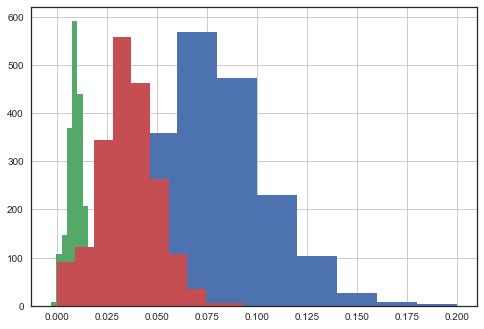

In [19]:
#roughly compare distributions of first three Word2Vec features
for idx in range(3):
    pros_sentences_vectors_df.loc[:,idx].hist()

In [20]:
#Logistic Regression pipeline
lrp = Pipeline([('ss', StandardScaler()),
               ('lr', LogisticRegression(random_state=23))])

#C values for Logistic Regression
c_vals = np.logspace(-3,10,27)

print('Values for C: {}'.format(c_vals))

Values for C: [1.00000000e-03 3.16227766e-03 1.00000000e-02 3.16227766e-02
 1.00000000e-01 3.16227766e-01 1.00000000e+00 3.16227766e+00
 1.00000000e+01 3.16227766e+01 1.00000000e+02 3.16227766e+02
 1.00000000e+03 3.16227766e+03 1.00000000e+04 3.16227766e+04
 1.00000000e+05 3.16227766e+05 1.00000000e+06 3.16227766e+06
 1.00000000e+07 3.16227766e+07 1.00000000e+08 3.16227766e+08
 1.00000000e+09 3.16227766e+09 1.00000000e+10]


In [21]:
#reserve 75% of data for training
#stratify to make sure that equal representation of Culture & Values 
x_train_culture, x_test_culture, y_train_culture, y_test_culture = \
    train_test_split(pros_sentences_vectors_df, 
                     pros_sentences.loc[:,'Culture & Values'],
                    test_size=0.25,
                     stratify=pros_sentences.loc[:,'Culture & Values'],
                    random_state=23)

In [22]:
#do k-fold cross-validation to maintain class balance
skf = StratifiedKFold(n_splits=5, random_state=23)

In [32]:
start_time = time.time()

#create arrays to hold cross-validation stats
scr_mean_culture = np.zeros(c_vals.shape)
scr_std_culture = np.zeros(c_vals.shape)

for idx, c in enumerate(c_vals):
    lrp.set_params(lr__C = c)
    score = cross_val_score(lrp, x_train_culture, y_train_culture, cv=skf)
    scr_mean_culture[idx] = np.mean(score)
    scr_std_culture[idx] = np.std(score)
    
print('{} LogisticRegression models took {} seconds'.format(c_vals.shape[0], 
                                                            str(time.time() - start_time))
      

27 LogisticRegression models took 16.060067176818848 seconds.


In [33]:
#find best score
idx = np.argmax(scr_mean_culture)

#display best score with error and associated 'C" value

print(f'Best score = {scr_mean_culture[idx]:5.3f} +/- {scr_std_culture[idx]:5.3f}')
print(f'Best C param = {c_vals[idx]:5.3f}')

Best score = 0.722 +/- 0.011
Best C param = 10.000


In [34]:
#now perform standard performance testing by creating and applying model to test data

#set parameter to best value
lrp.set_params(lr__C = c_vals[idx])

#Train model and predict on test data
lrp.fit(x_train_culture, y_train_culture)
y_pred_culture = lrp.predict(x_test_culture)

#Generate classification report
print(classification_report(y_test_culture,y_pred_culture))

             precision    recall  f1-score   support

          0       0.77      0.87      0.82       317
          1       0.72      0.55      0.63       182

avg / total       0.75      0.76      0.75       499



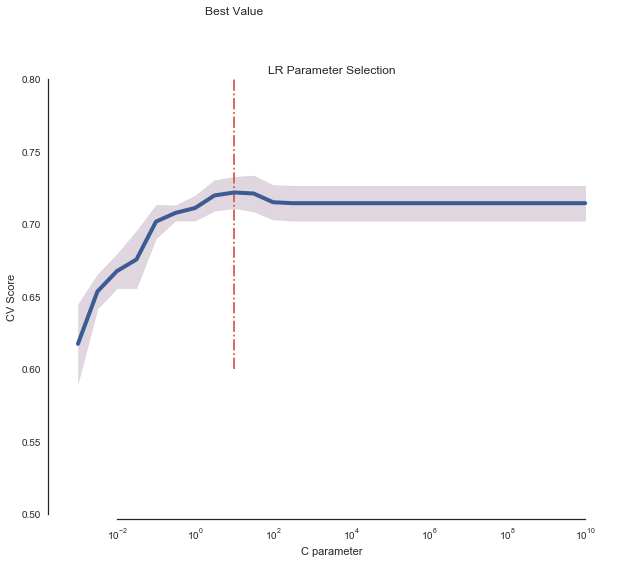

In [26]:
#Define confidence interval
high = scr_mean_culture + scr_std_culture
low = scr_mean_culture - scr_std_culture

#plot results
fig, ax = plt.subplots(figsize=(10,8))

# Plot confidence interval
ax.semilogx(c_vals, scr_mean_culture,
           color = sns.xkcd_rgb["denim blue"], linewidth=4)
ax.fill_between(c_vals, high, low,
               color=sns.xkcd_rgb['dusty purple'], alpha=0.25)

# Mark the best 'C' value
ax.vlines(c_vals[idx], 0.6, 0.8, linestyles='-.',
         color = sns.xkcd_rgb["pale red"])
ax.text(c_vals[idx], 0.85, 'Best Value',
       horizontalalignment='center',
       verticalalignment='top')

#Decorate plot
ax.set(title='LR Parameter Selection',
      xlabel='C parameter',
      ylabel='CV Score',
      ylim=(0.5, 0.8))

#ax.legend(loc=4, borderaxespad=1.5)
sns.despine(offset=5, trim=True)

## Classification with Random Forests and GridSearchCV

I will now compare the previous performance with that using Random Forest Classifiers.

In [27]:
#make Random Forest Classifier pipeline
rfcp = Pipeline([('ss', StandardScaler()),
               ('rfc', RandomForestClassifier(random_state=23))])

In [28]:
start_time = time.time()

#create dictionary of hyperparameters
#n_estimators = [10, 20, 50, 100, 150, 200, 250, 300] #find best number of estimators at 150
n_estimators = [120, 130, 140, 150, 160, 170, 180]
params = dict(rfc__n_estimators=n_estimators)

#create grid search cross validator
gse = GridSearchCV(estimator=rfcp, param_grid=params, cv=skf)

#fit estimator
gse.fit(x_train_culture, y_train_culture)

#Display time and best estimator results
print('Took {} seconds to train {} RFC"s'.format(time.time() - start_time, 
                                                 len(n_estimators)))

print('Best number of estimators = {0:5.4f}'.format(gse.best_estimator_.get_params()['rfc__n_estimators']))
print('Best CV Score = {0:4.3f}'.format(gse.best_score_))


Took 56.76226592063904 seconds to train 7 RFC"s
Best number of estimators = 140.0000
Best CV Score = 0.688


In [29]:
rfcp.set_params(rfc__n_estimators = 160)

rfcp.fit(x_train_culture, y_train_culture)
y_pred = rfcp.predict(x_test_culture)

print(classification_report(y_test_culture, y_pred))

             precision    recall  f1-score   support

          0       0.70      0.90      0.79       317
          1       0.65      0.34      0.45       182

avg / total       0.68      0.69      0.66       499



## Classification of Work/Life Balance

In [48]:
c_vals = np.logspace(-3,4,15)

c_vals

array([1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02,
       1.00000000e+03, 3.16227766e+03, 1.00000000e+04])

In [40]:
x_train_worklife, x_test_worklife, y_train_worklife, y_test_worklife = \
        train_test_split(pros_sentences_vectors_df, 
                         pros_sentences.loc[:,'Work/Life Balance'],
                         test_size=0.25,
                         stratify=pros_sentences.loc[:,'Work/Life Balance'],
                         random_state=23)

In [51]:
start_time = time.time()

#create arrays to hold CV stats
scr_mean_worklife = np.zeros(c_vals.shape)
scr_std_worklife = np.zeros(c_vals.shape)

for idx, c in enumerate(c_vals):
    lrp.set_params(lr__C = c)
    score = cross_val_score(lrp, x_train_worklife, y_train_worklife, cv=skf)
    scr_mean_worklife[idx] = np.mean(score)
    scr_std_worklife[idx] = np.std(score)
    
print('Training {} Logistic Regression models took {} seconds'.format(c_vals.shape[0], 
                                                                      str(time.time()-start_time)))

Training 15 Logistic Regression models took 6.406237363815308 seconds


In [52]:
idx = np.argmax(scr_mean_worklife)

#display best score with error and associated 'C' value

print('Best score = {0:5.3f} +/- {1:5.3f}'.format(scr_mean_worklife[idx], scr_std_worklife[idx]))
print('Best C param = {0:5.3f}'.format(c_vals[idx]))

Best score = 0.902 +/- 0.013
Best C param = 3.162


In [55]:
#now perform standard performance testing by creating and applying model to test data

#set parameter to best value
lrp.set_params(lr__C = c_vals[idx])

#Train model and predict on test data
lrp.fit(x_train_worklife, y_train_worklife)
y_pred_worklife = lrp.predict(x_test_worklife)

print('Accuracy score: {0:5.3f}%'.format(accuracy_score(y_pred_worklife, y_test_worklife) * 100))

#Generate classification report
print(classification_report(y_test_worklife,y_pred_worklife))

Accuracy score: 89.579%
             precision    recall  f1-score   support

          0       0.91      0.97      0.94       434
          1       0.68      0.38      0.49        65

avg / total       0.88      0.90      0.88       499



I'll now try to train with Random Forest Classifiers.

In [63]:
start_time = time.time()

n_estimators = [10, 20, 50, 100, 150, 200, 250, 300]

#create arrays to hold CV stats
scr_mean_worklife_rfc = [0 for idx in range(len(n_estimators))]
scr_std_worklife_rfc = [0 for idx in range(len(n_estimators))]

for idx, n_est in enumerate(n_estimators):
    rfcp.set_params(rfc__n_estimators = n_est)
    score = cross_val_score(rfcp, x_train_worklife, y_train_worklife, cv=skf)
    scr_mean_worklife_rfc[idx] = np.mean(score)
    scr_std_worklife_rfc[idx] = np.std(score)
    
print('Training {} Random Forest Classifiers took {} seconds'.format(len(n_estimators), 
                                                                     str(time.time()-start_time)))

idx = np.argmax(scr_mean_worklife_rfc)

#display best score with error and associated 'C' value
print('Best score = {0:5.3f} +/- {1:5.3f}'.format(scr_mean_worklife_rfc[int(idx)], 
                                                  scr_std_worklife_rfc[int(idx)]))
print('Best number of estimators = {0:5.3f}'.format(n_estimators[int(idx)]))

#set parameter to best value
rfcp.set_params(rfc__n_estimators = n_estimators[idx])

#Train model and predict on test data
rfcp.fit(x_train_worklife, y_train_worklife)
y_pred_worklife_rfc = lrp.predict(x_test_worklife)

print('Accuracy score: {0:5.3f}%'.format(accuracy_score(y_pred_worklife_rfc, 
                                                        y_test_worklife) * 100))

#Generate classification report
print(classification_report(y_test_worklife,y_pred_worklife_rfc))

Training 8 Random Forest Classifiers took 52.736732959747314 seconds
Best score = 0.888 +/- 0.010
Best number of estimators = 10.000
Accuracy score: 89.579%
             precision    recall  f1-score   support

          0       0.91      0.97      0.94       434
          1       0.68      0.38      0.49        65

avg / total       0.88      0.90      0.88       499



In [59]:
np.asarray(n_estimators)

array([ 10,  20,  50, 100, 150, 200, 250, 300])

## Classification of Senior Management

Using Logistic Regression, I see some troubling performance when classifying Senior Management. The recall for predicting Senior Management is only 0.19. While I think precision is more important for us than recall, this is still very poor performance. I will not want to use these for my final models.

In [64]:
x_train_sm, x_test_sm, y_train_sm, y_test_sm = \
        train_test_split(pros_sentences_vectors_df, 
                         pros_sentences.loc[:,'Senior Management'],
                         test_size=0.25,
                         stratify=pros_sentences.loc[:,'Senior Management'],
                         random_state=23)

In [68]:
start_time = time.time()

#create arrays to hold cross-validation stats
scr_mean_sm = np.zeros(c_vals.shape)
scr_std_sm = np.zeros(c_vals.shape)

for idx, c in enumerate(c_vals):
    lrp.set_params(lr__C = c)
    score = cross_val_score(lrp, x_train_sm, y_train_sm, cv=skf)
    scr_mean_sm[idx] = np.mean(score)
    scr_std_sm[idx] = np.std(score)
    
print('{} LogisticRegression models took {} seconds'.format(c_vals.shape[0],
                                                            str(time.time() - start_time))
    
#find best score
idx = np.argmax(scr_mean_sm)

#display best score with error and associated 'C" value

print(f'Best score = {scr_mean_sm[idx]:5.3f} +/- {scr_std_sm[idx]:5.3f}')
print(f'Best C param = {c_vals[idx]:5.3f}')

#now perform standard performance testing by creating and applying model to test data

#set parameter to best value
lrp.set_params(lr__C = c_vals[idx])

#Train model and predict on test data
lrp.fit(x_train_sm, y_train_sm)
y_pred_sm = lrp.predict(x_test_sm)

#Generate classification report
print(classification_report(y_test_sm,y_pred_sm))

15 LogisticRegression models took 9.241894721984863 seconds.
Best score = 0.920 +/- 0.007
Best C param = 1.000
             precision    recall  f1-score   support

          0       0.93      1.00      0.96       456
          1       1.00      0.19      0.31        43

avg / total       0.93      0.93      0.91       499



In [77]:
start_time = time.time()

#create arrays to hold cross-validation stats
scr_mean_sm = np.zeros(c_vals.shape)
scr_std_sm = np.zeros(c_vals.shape)

params = dict(lr__C=c_vals, lr__penalty=['l1','l2'])

gse = GridSearchCV(estimator=lrp, param_grid=params, cv=skf)

gse.fit(x_train_sm, y_train_sm)

print('Took {} seconds.'.format(time.time()-start_time))

print('Best C param = {}'.format(gse.best_estimator_.get_params()['lr__C']))
print('Best penalty = {}'.format(gse.best_estimator_.get_params()['lr__penalty']))

print('Best CV score = {}'.format(gse.best_score_))

lrp.set_params(lr__C = gse.best_estimator_.get_params()['lr__C'], lr__penalty = gse.best_estimator_.get_params()['lr__penalty'])

lrp.fit(x_train_sm, y_train_sm)
y_pred = lrp.predict(x_test_sm)

print(classification_report(y_test_sm, y_pred))

Took 332.70547890663147 seconds.
Best C param = 1.0
Best penalty = l2
Best CV score = 0.9203480589022758
             precision    recall  f1-score   support

          0       0.93      1.00      0.96       456
          1       1.00      0.19      0.31        43

avg / total       0.93      0.93      0.91       499



## Classification on Comp & Benefits

Again, I see very poor recall of 0.19, this time when predicting 'Comp & Benefits'.

In [67]:
x_train_cb, x_test_cb, y_train_cb, y_test_cb = \
        train_test_split(pros_sentences_vectors_df, 
                         pros_sentences.loc[:,'Comp & Benefits'],
                         test_size=0.25,
                         stratify=pros_sentences.loc[:,'Comp & Benefits'],
                         random_state=23)

In [69]:
start_time = time.time()

#create arrays to hold cross-validation stats
scr_mean_cb = np.zeros(c_vals.shape)
scr_std_cb = np.zeros(c_vals.shape)

for idx, c in enumerate(c_vals):
    lrp.set_params(lr__C = c)
    score = cross_val_score(lrp, x_train_cb, y_train_cb, cv=skf)
    scr_mean_cb[idx] = np.mean(score)
    scr_std_cb[idx] = np.std(score)
    
print('{} LogisticRegression models took {} seconds'.format(c_vals.shape[0],
                                                            str(time.time() - start_time)) 
#find best score
idx = np.argmax(scr_mean_sm)

#display best score with error and associated 'C" value

print(f'Best score = {scr_mean_sm[idx]:5.3f} +/- {scr_std_sm[idx]:5.3f}')
print(f'Best C param = {c_vals[idx]:5.3f}')

#now perform standard performance testing by creating and applying model to test data

#set parameter to best value
lrp.set_params(lr__C = c_vals[idx])

#Train model and predict on test data
lrp.fit(x_train_sm, y_train_sm)
y_pred_sm = lrp.predict(x_test_sm)

#Generate classification report
print(classification_report(y_test_sm,y_pred_sm))

15 LogisticRegression models took 7.787758111953735 seconds.
Best score = 0.920 +/- 0.007
Best C param = 1.000
             precision    recall  f1-score   support

          0       0.93      1.00      0.96       456
          1       1.00      0.19      0.31        43

avg / total       0.93      0.93      0.91       499



In [75]:
start_time = time.time()

#create arrays to hold cross-validation stats
scr_mean_cb = np.zeros(c_vals.shape)
scr_std_cb = np.zeros(c_vals.shape)

params = dict(lr__C=c_vals, lr__penalty=['l1','l2'])

gse = GridSearchCV(estimator=lrp, param_grid=params, cv=skf)

gse.fit(x_train_cb, y_train_cb)

#display best score with error and associated 'C" value

print('Best C param = {}'.format(gse.best_estimator_.get_params()['lr__C']))
print('Best penalty = {}'.format(gse.best_estimator_.get_params()['lr__penalty']))

print('Best CV score = {}'.format(gse.best_score_))

Best C param = 10.0
Best penalty = l1
Best CV score = 0.8078982597054887


In [76]:
lrp.set_params(lr__C = 10, lr__penalty = 'l1')

lrp.fit(x_train_cb, y_train_cb)
y_pred = lrp.predict(x_test_cb)

print(classification_report(y_test_cb, y_pred))

             precision    recall  f1-score   support

          0       0.82      0.93      0.87       338
          1       0.80      0.58      0.67       161

avg / total       0.82      0.82      0.81       499



## Classification on Career Opportunities

In [71]:
x_train_co, x_test_co, y_train_co, y_test_co = \
        train_test_split(pros_sentences_vectors_df, 
                         pros_sentences.loc[:,'Career Opportunities'],
                         test_size=0.25,
                         stratify=pros_sentences.loc[:,'Career Opportunities'],
                         random_state=23)

In [73]:
start_time = time.time()

#create arrays to hold cross-validation stats
scr_mean_co = np.zeros(c_vals.shape)
scr_std_co = np.zeros(c_vals.shape)

for idx, c in enumerate(c_vals):
    lrp.set_params(lr__C = c)
    score = cross_val_score(lrp, x_train_cb, y_train_cb, cv=skf)
    scr_mean_co[idx] = np.mean(score)
    scr_std_co[idx] = np.std(score)
    
print('{} LogisticRegression models took {} seconds'.format(c_vals.shape[0],
                                                            str(time.time() - start_time))
    
#find best score
idx = np.argmax(scr_mean_co)

#display best score with error and associated 'C" value

print(f'Best score = {scr_mean_co[idx]:5.3f} +/- {scr_std_co[idx]:5.3f}')
print(f'Best C param = {c_vals[idx]:5.3f}')

#now perform standard performance testing by creating and applying model to test data

#set parameter to best value
lrp.set_params(lr__C = c_vals[idx])

#Train model and predict on test data
lrp.fit(x_train_co, y_train_co)
y_pred_co = lrp.predict(x_test_co)

#Generate classification report
print(classification_report(y_test_co,y_pred_co))

15 LogisticRegression models took 6.037069797515869 seconds.
Best score = 0.803 +/- 0.012
Best C param = 316.228
             precision    recall  f1-score   support

          0       0.87      0.95      0.91       405
          1       0.64      0.37      0.47        94

avg / total       0.82      0.84      0.82       499



# Predicting Cons

We will now do everything for CONs. This includes training a Word2Vec model and then training classifiers.

## Tokenize labeled cons sentences

In [19]:
#create new column of tokens in each sentence
cons_sentences.loc[:,'tokens'] = cons_sentences.loc[:,'CONs_sentence'].\
    apply(lambda sentence: tokenize_a_sentence(sentence, tokenizer))

In [21]:
#number of dimensions for Word2Vec model
dim = 100

#train Word2Vec model on tokens
model_cons = gensim.models.Word2Vec(list(cons_sentences.loc[:,'tokens']), size=dim)
w2v_cons = dict(zip(model_cons.wv.index2word, model_cons.wv.vectors))

In [22]:
#check that it contains some commonly used words
assert(model_cons.wv.__contains__('opportunity'))
assert(model_cons.wv.__contains__('work'))
assert(model_cons.wv.__contains__('benefits'))

In [23]:
#store Word2Vec representation of each CON sentence
cons_sentences_vectors_array = np.zeros((cons_sentences.shape[0], dim))

for idx in range(cons_sentences.shape[0]):
    cons_sentences_vectors_array[idx] = average_of_tokens(cons_sentences.loc[idx,'tokens'])    

/Users/derekjung/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:11: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/Users/derekjung/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [24]:
cons_sentences_vectors_df = pd.DataFrame(cons_sentences_vectors_array)

## Classification of Culture & Values with Logistic Regression

In [25]:
#reserve 75% of data for training
#stratify to make sure that equal representation of Culture & Values and not in training/testing
x_train_culture, x_test_culture, y_train_culture, y_test_culture = \
    train_test_split(cons_sentences_vectors_df, 
                     cons_sentences.loc[:,'Culture & Values'],
                    test_size=0.25,
                     stratify=cons_sentences.loc[:,'Culture & Values'],
                    random_state=23)

In [29]:
c_vals = np.logspace(-3,4,15)

#Logistic Regression pipeline
lrp = Pipeline([('ss', StandardScaler()),
               ('lr', LogisticRegression(random_state=23))])

#do k-fold cross-validation to maintain class balance
skf = StratifiedKFold(n_splits=5, random_state=23)

In [30]:
start_time = time.time()

params = dict(lr__C=c_vals, lr__penalty=['l1','l2'])

gse = GridSearchCV(estimator=lrp, param_grid=params, cv=skf)

gse.fit(x_train_culture, y_train_culture)

print('Took {} seconds.'.format(time.time()-start_time))

print('Best C param = {}'.format(gse.best_estimator_.get_params()['lr__C']))
print('Best penalty = {}'.format(gse.best_estimator_.get_params()['lr__penalty']))

print('Best CV score = {}'.format(gse.best_score_))

lrp.set_params(lr__C = gse.best_estimator_.get_params()['lr__C'], lr__penalty = gse.best_estimator_.get_params()['lr__penalty'])

lrp.fit(x_train_culture, y_train_culture)
y_pred = lrp.predict(x_test_culture)

print(classification_report(y_test_culture, y_pred))

Took 151.5967719554901 seconds.
Best C param = 3.1622776601683795
Best penalty = l2
Best CV score = 0.68
             precision    recall  f1-score   support

          0       0.70      0.86      0.77       328
          1       0.53      0.31      0.39       172

avg / total       0.64      0.67      0.64       500



In [31]:
categories = ['Culture & Values', 'Work/Life Balance', 'Senior Management', 
              'Comp & Benefits', 'Career Opportunities']

In [33]:
#train Logistic Regression with Stratified K-fold and GridSearch on every category
for cat in categories:
    
    start_time = time.time()

    print('-'*50)
    print(cat)
    x_train, x_test, y_train, y_test = \
    train_test_split(cons_sentences_vectors_df,
                     cons_sentences.loc[:,cat],
                     test_size=0.25,
                     stratify=cons_sentences.loc[:,cat],
                     random_state=23)
    

    params = dict(lr__C=c_vals, lr__penalty=['l1','l2'])

    gse = GridSearchCV(estimator=lrp, param_grid=params, cv=skf)

    gse.fit(x_train, y_train)


    print('Best C param = {}'.format(gse.best_estimator_.get_params()['lr__C']))
    print('Best penalty = {}'.format(gse.best_estimator_.get_params()['lr__penalty']))

    print('Best CV score = {}'.format(gse.best_score_))

    lrp.set_params(lr__C = gse.best_estimator_.get_params()['lr__C'], lr__penalty = gse.best_estimator_.get_params()['lr__penalty'])

    lrp.fit(x_train, y_train)
    y_pred = lrp.predict(x_test)

    print(classification_report(y_test, y_pred))

    print('Took {} seconds.'.format(time.time()-start_time))
    
    start_time = time.time()

--------------------------------------------------
Culture & Values
Best C param = 3.1622776601683795
Best penalty = l2
Best CV score = 0.68
             precision    recall  f1-score   support

          0       0.70      0.86      0.77       328
          1       0.53      0.31      0.39       172

avg / total       0.64      0.67      0.64       500

Took 134.52920722961426 seconds.
--------------------------------------------------
Work/Life Balance
Best C param = 1.0
Best penalty = l2
Best CV score = 0.8946666666666667
             precision    recall  f1-score   support

          0       0.90      0.98      0.94       441
          1       0.57      0.22      0.32        59

avg / total       0.86      0.89      0.87       500

Took 130.51529574394226 seconds.
--------------------------------------------------
Senior Management
Best C param = 10.0
Best penalty = l1
Best CV score = 0.8886666666666667
             precision    recall  f1-score   support

          0       0.90    